In [48]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = json.load(open('../log.json'))

In [16]:
world = [
    d for d in data if "data" in d and "World" in d["data"]
]
debug = [
    d for d in data if "data" in d and "Debug" in d["data"]
]

In [29]:
len(dict())

0

In [95]:
player = {
    w["timestamp"]: w["data"]["World"]["own_players"][0] for w in world if len(w["data"]["World"]["own_players"]) > 0
}
player_debug = {
    d["timestamp"]: { k[3:]: v for k, v in d["data"]["Debug"].items() if k.startswith("p0") and len(v) > 0 } for d in debug if len(d["data"]["Debug"]) > 0
}
mtp_mode = {d["timestamp"]: {k: v["data"] for k, v in d["data"]["Debug"].items() if k.startswith("p5")} for d in debug if len(d["data"]["Debug"]) > 0 and "p5.MTPMode" in d["data"]["Debug"]}

shorter = player if len(player) < len(player_debug) else player_debug
longer = player_debug if len(player) < len(player_debug) else player
merged_player = {}
for t, p in shorter.items():
    closest = min(longer.keys(), key=lambda x: abs(x - t))
    closest_mtp = min(mtp_mode.keys(), key=lambda x: abs(x - t))
    merged_player[t] = {**p, **longer[closest], **mtp_mode[closest_mtp]}

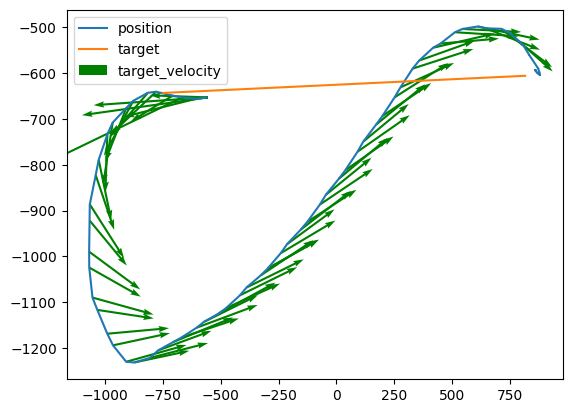

In [85]:
targets = np.array([p["control.target"]["data"]["data"]["center"] for p in merged_player.values() if "control.target" in p])
local_u = np.array([[p["sx"]["data"], p["sy"]["data"]] for p in merged_player.values() if "sx" in p])

orientation = np.array([[np.cos(p["yaw"]), np.sin(p["yaw"])] for p in merged_player.values()])

positions = np.array([p["position"] for p in merged_player.values()])
velocities = np.array([p["velocity"] for p in merged_player.values()])

target_vel_end = np.array([p["target_velocity"]["data"]["data"]["end"] for p in merged_player.values() if "target_velocity" in p])
target_vel_start = np.array([p["target_velocity"]["data"]["data"]["start"] for p in merged_player.values() if "target_velocity" in p])
target_velocities = target_vel_end - target_vel_start

# plt.plot(positions[:, 0], positions[:, 1], label="position")
# animate with slider
fig, ax = plt.subplots()
t_start = 5
t_end = 10

idx1 = next((i for i, p in enumerate(merged_player.keys()) if p > t_start), 0)
idx2 = next((i for i, p in enumerate(merged_player.keys()) if p > t_end), -1)

ax.plot(positions[idx1:idx2, 0], positions[idx1:idx2, 1], label="position")
ax.plot(targets[idx1:idx2, 0], targets[idx1:idx2, 1], label="target")
# ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], velocities[idx1:idx2, 0], velocities[idx1:idx2, 1], label="velocity")
# ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], local_u[idx1:idx2, 0], local_u[idx1:idx2, 1], label="local_u", color="r")
# ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], orientation[idx1:idx2, 0], orientation[idx1:idx2, 1], label="orientation")
ax.quiver(positions[idx1:idx2, 0], positions[idx1:idx2, 1], target_velocities[idx1:idx2, 0], target_velocities[idx1:idx2, 1], label="target_velocity", color="g")
ax.legend()
plt.show()


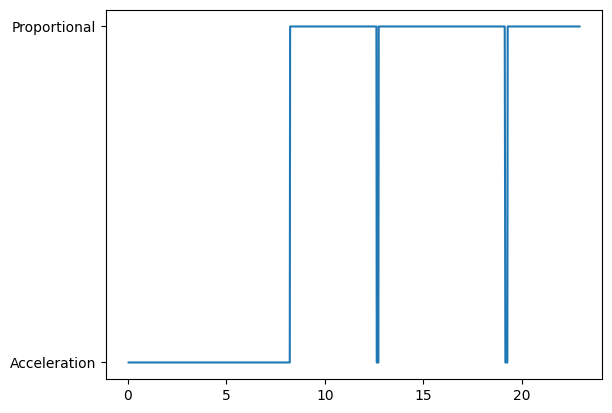

In [102]:
mtp = [p["p5.MTPMode"] for t, p in merged_player.items() if "p5.MTPMode" in p]
mtp_t = [t for t, p in merged_player.items() if "p5.MTPMode" in p]
plt.plot(mtp_t, mtp)